# FinCast 真实未来预测 (Real Future Forecast)

此 Notebook 用于加载最新数据并对**未来**进行预测（不进行遮挡验证）。

This notebook loads the latest data and forecasts into the **unknown future** (without masking data for validation).

In [1]:
import json
import os
import sys
import time
import numpy as np
import pandas as pd
import glob
from types import SimpleNamespace

from data_tools.TSdataset import TimeSeriesDataset_MultiCSV_train_Production
from tools.inference_utils import FinCast_Inference, plot_last_outputs

Loaded PyTorch FinCast, python version 3.11.11 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:34:19) [MSC v.1929 64 bit (AMD64)].


In [2]:
# === 1. 设置路径 (Setup Paths) ===

# 自动检测 input 文件夹中最新的 csv
input_folder = r"d:\Projects\Python\Fincast\FinCast-fts\input"
csv_files = glob.glob(os.path.join(input_folder, "*.csv"))
# 过滤掉验证临时文件
csv_files = [f for f in csv_files if "_val_input" not in f]

if csv_files:
    data_path = max(csv_files, key=os.path.getmtime)
    print(f"Data file selected: {data_path}")
else:
    data_path = "" 
    print("WARNING: No CSV file found in input/ folder.")

# 模型路径
model_path = r"d:\Projects\Python\Fincast\FinCast-fts\checkpoints\v1.pth"
save_output_path = r"d:\Projects\Python\Fincast\FinCast-fts\output"

Data file selected: d:\Projects\Python\Fincast\FinCast-fts\input\600869.SH.csv


In [3]:
# === 2. 配置参数 (Configuration) ===

config = SimpleNamespace()

# Device
config.backend = "gpu"  # cpu or gpu

# Model
config.model_path = model_path
config.model_version = "v1"

# Data
config.data_path = data_path
config.data_frequency = "m"       # m=minute, h=hour, d=day
config.context_len = 1024          # Input length
config.horizon_len =  64          # Future steps to predict

# 关键：False 表示只取最后一段数据进行一次预测
config.all_data = False               
config.columns_target = ['Close'] 
config.series_norm = False
config.batch_size = 64

# Output
config.forecast_mode = "mean"
config.quantile_outputs = []
config.save_output = True
config.save_output_path = save_output_path

# Visualization
config.plt_outputs = True
config.plt_quantiles = [1, 3, 7, 9]

print(f"Ready to forecast the NEXT {config.horizon_len} steps based on historical data.")

Ready to forecast the NEXT 64 steps based on historical data.


In [4]:
# === 3. 执行推理 (Run Inference) ===

fincast_inference = FinCast_Inference(config)

print("Starting inference...")
preds, mapping, full_outputs = fincast_inference.run_inference()
print("Inference Done.")

Starting inference...
Inference Done.


C:\Users\YingchaoLv\AppData\Local\Temp\ipykernel_26760\1342569345.py:45: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_dates = pd.date_range(start=last_date, periods=len(pred_values)+1, freq=freq)[1:]


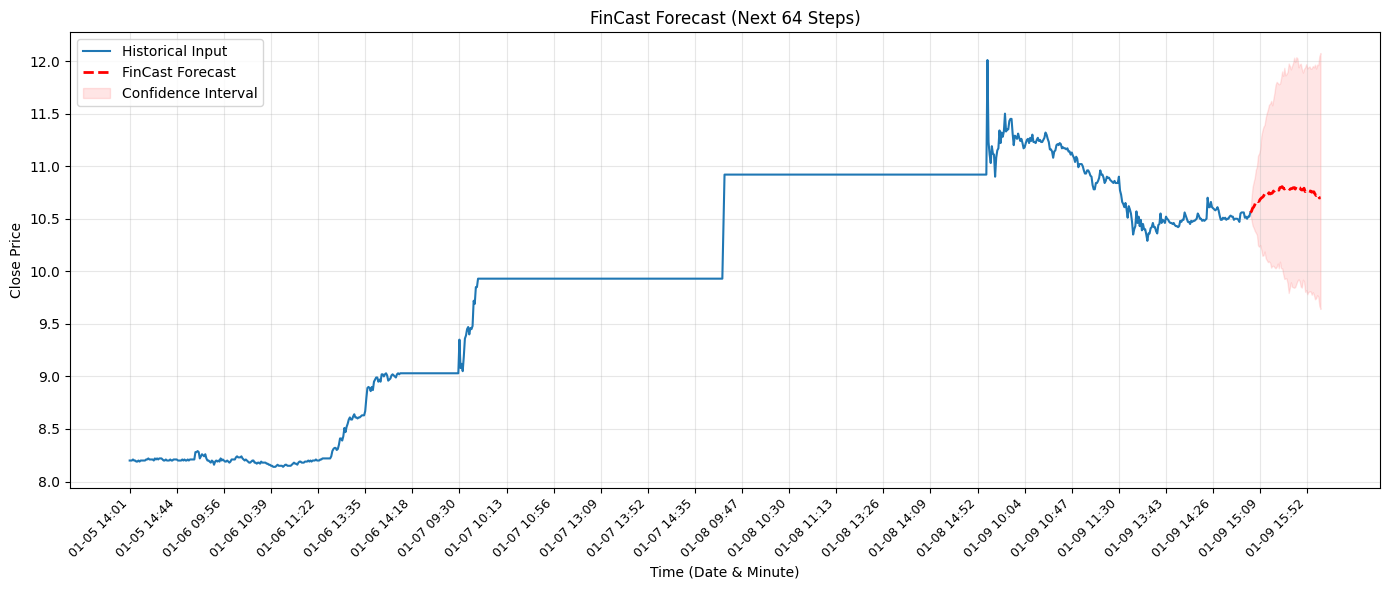

In [5]:
# === 4. 绘图 (Visualization) ===
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

if getattr(config, "plt_outputs", True):
    # 1. 获取输入历史 (Context)
    ctx_len = config.context_len
    dataset_obj = fincast_inference.inference_dataset
    context_values = dataset_obj.series_arrays[0][-ctx_len:]
    
    # 2. 获取预测结果 (Prediction)
    pred_values = preds[0]
    
    # 3. 构造坐标轴
    x_ctx = np.arange(len(context_values))
    x_fut = np.arange(len(context_values), len(context_values) + len(pred_values))
    
    # 消除断层：连接历史最后一点
    last_ctx_val = context_values[-1]
    x_connect = np.concatenate(([x_ctx[-1]], x_fut))
    pred_connect = np.concatenate(([last_ctx_val], pred_values))
    
    # 4. 生成未来时间标签
    has_dates = False
    all_dates = None
    
    try:
        # 重新读取数据以获取时间列
        df = pd.read_csv(config.data_path)
        if 'date' in df.columns:
            if not pd.api.types.is_datetime64_any_dtype(df['date']):
                df['date'] = pd.to_datetime(df['date'])
            
            # 历史时间
            ctx_dates = df['date'].iloc[-len(context_values):].values
            last_date = pd.to_datetime(ctx_dates[-1])
            
            # 这里的频率映射可以根据需要调整，默认处理 'm'=Minute
            freq_map = {"m": "T", "h": "H", "d": "D", "s": "S"}
            freq = freq_map.get(config.data_frequency, "T")
            
            # 生成未来时间序列
            future_dates = pd.date_range(start=last_date, periods=len(pred_values)+1, freq=freq)[1:]
            
            all_dates = np.concatenate([ctx_dates, future_dates])
            has_dates = True
    except Exception as e:
        print(f"Date generation failed: {e}")

    # 5. 开始绘图
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # 绘制历史
    ax.plot(x_ctx, context_values, label="Historical Input", color="#1f77b4", linewidth=1.5)
    
    # 绘制预测
    ax.plot(x_connect, pred_connect, label="FinCast Forecast", color="red", linestyle="--", linewidth=2)
    
    # 绘制置信区间
    if full_outputs is not None:
        from tools.inference_utils import _validate_quantile_requests
        full_sel = full_outputs[0:1]
        req_qs = getattr(config, "plt_quantiles", [])
        qmap = _validate_quantile_requests(full_sel, req_qs)
        
        if qmap:
             lowest_q_idx = qmap[0][1]
             highest_q_idx = qmap[-1][1]
             y_low = full_sel[0, :, lowest_q_idx]
             y_high = full_sel[0, :, highest_q_idx]
             
             y_low_connect = np.concatenate(([last_ctx_val], y_low))
             y_high_connect = np.concatenate(([last_ctx_val], y_high))
             
             ax.fill_between(x_connect, y_low_connect, y_high_connect, color='red', alpha=0.1, label="Confidence Interval")

    ax.set_title(f"FinCast Forecast (Next {len(pred_values)} Steps)")
    ax.set_ylabel("Close Price")
    ax.legend(loc="upper left")
    ax.grid(True, alpha=0.3)
    
    # X轴刻度优化
    if has_dates and all_dates is not None:
        total_len = len(all_dates)
        num_ticks = 25
        step = max(1, total_len // num_ticks)
        
        tick_indices = np.arange(0, total_len, step)
        tick_labels = [pd.to_datetime(all_dates[i]).strftime('%m-%d %H:%M') for i in tick_indices]
        
        ax.set_xticks(tick_indices)
        ax.set_xticklabels(tick_labels, rotation=45, ha="right", fontsize=9)
        ax.set_xlabel("Time (Date & Minute)")
    else:
        ax.set_xlabel("Time Steps")

    plt.tight_layout()
    plt.show()